
<h1 id="Assessment">Assessment<a class="anchor-link" href="#Assessment">¶</a></h1>



<h2 id="Question-5">Question 5<a class="anchor-link" href="#Question-5">¶</a></h2>



<p>The registrations dataset contains customer details which was harvested when they registered for or activated a product or service within the Pepkor group. You need to do the following:</p>
<p>a. Analyse and show the following statistics:</p>
<ul>
<li>Number of unique customers</li>
<li>Gender distribution</li>
<li>Average age of customers</li>
<li>Number of laybyes per subsidiary as percentage of overall number of laybyes (hint: sk_subsidiary_no &lt;&gt; prod_subsidiary_no)</li>
<li>Median age of ‘Competition 6’ customers</li>
</ul>
<p>b. Add additional analyses based on the registration dataset that you picked up, including two graphs of your own choice and document two findings/insights from this dataset (Do not overthink it).</p>



<p>Start by importing the relevant libraries</p>


In [1]:

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



/tmp/ipykernel_13517/427504256.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd



<p>Then load in the excel file and separate the sheets into separate DataFrames in Pandas</p>


In [2]:

p = Path.home() / 'pepkor-test' 
xls = pd.ExcelFile(p / 'data' / 'Assessment.xlsx')
sheet_names = xls.sheet_names
df_list = [pd.read_excel(xls, sheet_name=sheet) for sheet in sheet_names]
registration, transactions, dim_cust_prod, dim_subsidiary = df_list




<p>The number of unique customers is 9969</p>


In [3]:

print(registration.SK_CUST_NO.nunique())



9969



<p>The gender distribution is 80 percent women, 20 percent men.</p>


In [4]:

print(registration.GENDER_IND.value_counts(normalize=True))



GENDER_IND
F    0.801736
M    0.198264
Name: proportion, dtype: float64



<p>To calculate the average age of customers, we first get the ages</p>


In [5]:

today = pd.to_datetime('today')
registration['AGE'] = registration.BIRTH_DATE.apply(lambda x: today - x)
registration['AGE'] = registration['AGE'] / np.timedelta64(365, 'D')
print(registration[['AGE', 'BIRTH_DATE']].head())



         AGE BIRTH_DATE
0  53.010456 1971-02-13
1  52.385798 1971-09-29
2  44.100867 1980-01-09
3  47.615935 1976-07-05
4  43.857031 1980-04-07



<p>Then take the average to get</p>


In [6]:

print(registration['AGE'].mean())



42.08705549921488



<p>Next we find the number of laybyes per subsidiary. Start by merging the <code>registration</code> table with the <code>dim_subsidary</code> table</p>


In [7]:

merged = registration.merge(
            dim_subsidiary, 
            left_on='SK_SOURCE_SUBSIDIARY_NO', 
            right_on='SK_SUBSIDIARY_NO').drop(['SUBSIDIARY_NO', 'SUBSIDIARY_ABBR'], axis=1)    




<p>Then we subset the data to take only the laybyes</p>


In [8]:

merged_laybyes = merged[merged.CUST_PROD_DESC == 'LAYBYE']




<p>Finally we get the count by subsidiary and divide by the total to get the proportions</p>


In [9]:

counts = merged_laybyes.groupby('SUBSIDIARY_NAME').count()['SK_CUST_PROD_NO'] 
print(counts / len(merged_laybyes))
    



SUBSIDIARY_NAME
Ackermans           0.531265
Pep                 0.350232
Speciality Group    0.118503
Name: SK_CUST_PROD_NO, dtype: float64



<p>The <code>dim_cust_prod</code> data also has information on laybyes, so we repeat the procedure there as well</p>


In [10]:

merged_dim_cust = dim_cust_prod.merge(
            dim_subsidiary,
            left_on='PROD_SUBSIDIARY_NO',
            right_on='SK_SUBSIDIARY_NO').drop(['SUBSIDIARY_NO', 'SUBSIDIARY_ABBR'], axis=1)

merged_dim_cust_laybye = merged_dim_cust[
            merged_dim_cust.PROD_GRP_NAME == 'Laybye']
    



In [11]:

print(
    merged_dim_cust_laybye.groupby('SUBSIDIARY_NAME').count()['SK_CUST_PROD_NO'] / len(merged_dim_cust_laybye)
)



SUBSIDIARY_NAME
Ackermans     0.1
Dunns         0.1
FutureCELL    0.1
John Craig    0.1
NONE          0.1
Pep           0.5
Name: SK_CUST_PROD_NO, dtype: float64



<p>To find the median age of 'competition 6' customers, we first merge the <code>registration</code> and <code>dim_cust_prod</code> tables</p>


In [12]:

merged_reg_cust = registration.merge(
            dim_cust_prod,
            on='SK_CUST_PROD_NO')




<p>Then we subset for the 'competition 6' customers. There are none.</p>


In [13]:

comp6 = merged_reg_cust[merged_reg_cust.CUST_PROD_DESC_y == 'COMPETITION 6']
print(comp6)



Empty DataFrame
Columns: [SK_CUST_PROD_NO, SK_SOURCE_SUBSIDIARY_NO, SK_CUST_NO, CUST_REF_CODE, BIRTH_DATE, TAKE_UP_DATE, GENDER_IND, VALID_EMAIL_ADD_IND, CELL_PHONE, EMAIL_ADD, FIRST_NAME, HOME_PHONE, LAST_NAME, WORK_PHONE, HOME_ADD_LINE1, HOME_ADD_LINE2, HOME_ADD_LINE3, HOME_POST_CODE, WORK_ADD_LINE1, WORK_ADD_LINE2, WORK_ADD_LINE3, WORK_POST_CODE, POSTAL_ADD_LINE1, POSTAL_ADD_LINE2, POSTAL_ADD_LINE3, POSTAL_POST_CODE, CUST_PROD_DESC_x, Question, Answer, All work was done in Python. There is an accompanying Jupyter notebook to explain the code, Unnamed: 30, Unnamed: 31, AGE, CUST_PROD_NO, CUST_PROD_DESC_y, PROD_SUBSIDIARY_NO, PROD_GRP_NAME, MSISDN_PREFIX, COUNTRY_CODE]
Index: []

[0 rows x 39 columns]



<p>One interesting finding is that the average age is highest for bill payments. We also note that the average of age of men for shoe city is 51; for women it is 36.</p>


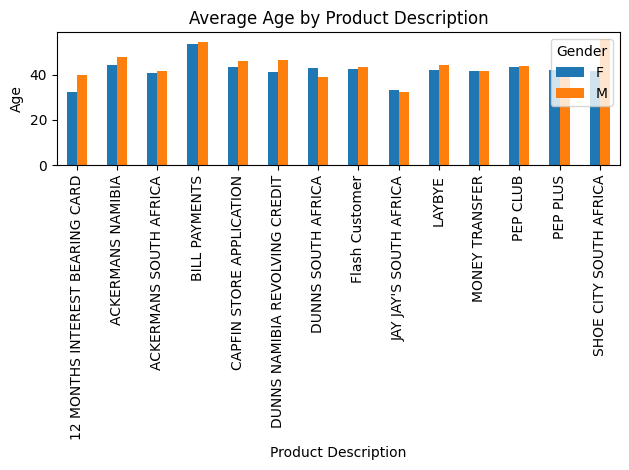

In [14]:

gender_group = registration.groupby(['CUST_PROD_DESC', 'GENDER_IND'])['AGE'].mean()
gender_group.unstack().plot(kind='bar')
plt.xlabel('Product Description')
plt.ylabel('Age')
plt.legend(title='Gender')
plt.title('Average Age by Product Description')
plt.tight_layout()
plt.show()




<p>A second finding is that, from a logistic regression, a one year increase in age is associated with at most a 0.02 percent decrease in having a valid email.</p>



<p><img alt="title" src="img/email_age_probability.png"/></p>



<p>From the same regression output, a man is also at most 16 percent more likely to have a valid email than a woman. Here a woman is coded as 0 and a man as 1</p>



<p><img alt="title" src="img/email_gender_probability.png"/></p>



<h2 id="Question-6">Question 6<a class="anchor-link" href="#Question-6">¶</a></h2>



<p>The transactions dataset contains point of sale basket information for one of the Pepkor brands. You need to do the following:</p>
<p>a. Analyse and show the following statistics:</p>
<ul>
<li>Number of unique customers that shopped </li>
<li>Average transaction (basket) value (hint: trn_no_code)</li>
<li>Average sk_store_no</li>
<li>How many stores per subsidiary in this dataset</li>
<li>If someone mentioned to you that the sales for this specific date were significantly lower than two days prior, what do you think could be possible reasons for it?</li>
</ul>
<p>b.  Add additional analyses based on the transactions dataset that you picked up, including two graphs of your own choice and document two findings/insights from this dataset (Do not overthink it).</p>



<p>There are 22 unique customers</p>


In [15]:

print(transactions.SK_CUST_NO.nunique())



22



<p>To find the average transaction value, I start by changing the negative transaction values to positive because this will affect the average.</p>


In [16]:

transactions.BINC_TRN_AMT = transactions.BINC_TRN_AMT.abs()




<p>If we use the simple average of <code>BINC_TRN_AMT</code>, we get 100. </p>


In [17]:

print(transactions.groupby('TRN_NO_CODE')['BINC_TRN_AMT'].mean())
print(transactions.BINC_TRN_AMT.mean())



TRN_NO_CODE
73135     117.950000
100249    138.300000
100252     24.310714
100254    126.616667
226124    112.302941
226125     29.500000
306568     35.170000
306569     38.407143
306571     79.950000
306573     20.483333
306577    100.733333
306587    156.616667
306592     38.725000
349965    499.500000
349971     49.666667
349973     99.950000
349974    150.950000
349976     22.950000
361653    199.950000
361659     99.950000
361668    514.000000
361677    129.475000
Name: BINC_TRN_AMT, dtype: float64
99.9964912280702



<p>The average <code>sk_store_no</code> is 2400.9</p>


In [18]:

print(transactions.SK_STORE_NO.mean())



2400.90350877193



<p>There are 2 stores per subsidiary</p>


In [19]:

print(transactions.groupby('SK_STORE_SUBSIDIARY_NO').SK_STORE_NO.nunique())



SK_STORE_SUBSIDIARY_NO
3    2
Name: SK_STORE_NO, dtype: int64



<p>If sales were lower on a day than the previous two days, it could be that sales are seasonal and that historically on this date, sales were lower.</p>
<p>The store hours could have been affected by public holiday and so sales could be lower.</p>
<p>It could also be because of changes in management at a particular store or subsidiary.</p>
<p>Another possibility is that the trend of sales is unstable to begin with.</p>



<p>One interesting finding is that the average transaction value of the store 2396 is 84.72 and for store 2409 it is 125.21. Store 2396 has a positive skew (75th percentile is R99.95); store 2409 has a slight negative skew (75th percentile is R149.95)</p>


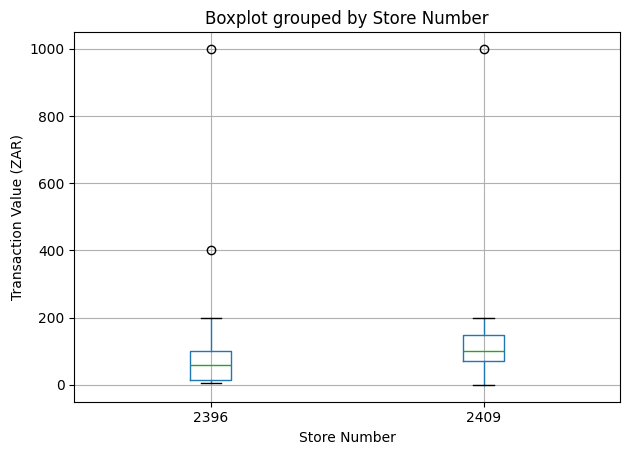

In [20]:

transactions.boxplot(column='BINC_TRN_AMT', by='SK_STORE_NO') 
plt.title('Boxplot grouped by Store Number')
plt.suptitle('')
plt.xlabel('Store Number')
plt.ylabel('Transaction Value (ZAR)')
plt.tight_layout()
plt.show()    




<p>Another finding is that Terminal No 2 has the lowest number of transactions at 5. Terminal No 4 has the highest number of transactions at 42. Terminal 3 has the highest median transaction value at R99.95. Terminal 1 has a positive skew with the 75 percentile at  R89</p>


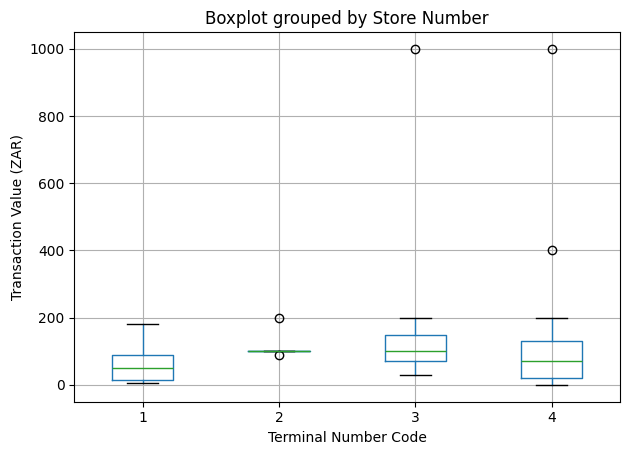

In [21]:

transactions.boxplot(column='BINC_TRN_AMT', by='TERMINAL_NO_CODE')
plt.title('Boxplot grouped by Store Number')
plt.suptitle('')
plt.xlabel('Terminal Number Code')
plt.ylabel('Transaction Value (ZAR)')
plt.tight_layout()
plt.show()




<p>I would have liked to explore the relationship between age and transaction value, but a merge with the <code>registrations</code> table on <code>SK_CUST_NO</code> turned up empty.</p>
